# hw 2
## Shadrunov Aleksey, BIB201

## task 1: bayes classification

In [87]:
from collections import defaultdict
from math import log
import pandas as pd
from sklearn.model_selection import train_test_split
from math import prod

split dataset for train and test with `sklearn train_test_split`:

In [88]:
names = pd.read_csv("names.csv", names=["name", "gender"], header=None)
X_train, X_test = train_test_split(names, test_size=0.3)

In [89]:
names

,name,gender
0,John,boy
1,William,boy
2,James,boy
3,Charles,boy
4,George,boy
...,...,...
6777,Laylah,girl
6778,Carleigh,girl
6779,Kenley,girl
6780,Sloane,girl


define functions:

In [90]:
def get_features(sample: str) -> str:
    """returns last letter as a feature of an object

    :param sample: input object (i. e. name)
    :type sample: str
    :return: feature (last letter)
    :rtype: str
    """
    return sample[-1]  # get last letter


def train(samples: list[tuple[str, str]]) -> tuple[dict, dict]:
    """input: [(feat, label), ('e', 'girl'), ('r', 'boy'), ... ('h', 'girl')]

    :param samples: [(feat, label), ('r', 'boy'), ... ('h', 'girl')]
    :type samples: list[tuple[str, str]]
    :return: dicts with names and probabilities of classes and features
    :rtype: tuple[dict, dict]
    """
    classes = defaultdict(lambda: 0)
    freq = defaultdict(lambda: 0)

    for feats, label in samples:
        classes[label] += 1  # count classes frequencies
        for feat in feats:
            freq[label, feat] += 1  # count features frequencies
        # freq[label, feats] += 1  # count features frequencies

    for label, feat in freq:  # normalize features frequencies
        freq[label, feat] /= classes[label]
    for c in classes:  # normalize classes frequencies
        classes[c] /= len(samples)

    print("number of classes:", len(classes))
    print("classes:", *classes.keys())
    print("number of features:", len(freq))
    # print(freq)
    return classes, freq  # return P(C) and P(O|C)


def classify(classifier, feats):
    classes, prob = classifier

    return min(
        classes.keys(),  # calculate argmin(-log(C|O))
        key=lambda cl: -log(classes[cl]) + sum(-log(prob.get((cl, feat), 0.001)) for feat in feats),
    )


select features:

In [91]:
features = [(get_features(feat), label) for feat, label in zip(X_train["name"], X_train["gender"])]
print(*features[:5], "...\n", sep="\n")


('a', 'girl')
('h', 'girl')
('a', 'girl')
('t', 'boy')
('a', 'girl')
...



train classifier to distinguish objects:

In [92]:
classifier = train(features)

number of classes: 2
classes: girl boy
number of features: 46


apply classifier to test dataset:

In [93]:
X_test["guess"] = X_test.apply(lambda row: classify(classifier, get_features(row["name"])), axis=1)
X_test

,name,gender,guess
267,Isaiah,boy,girl
911,Albertus,boy,boy
3324,Kamari,boy,girl
4692,Clotilda,girl,girl
6170,Kyrie,girl,girl
...,...,...,...
2119,Gilmore,boy,girl
3813,Amalia,girl,girl
2517,Andra,boy,girl
1733,Zebulon,boy,boy


calc accuracy as a proportion of correct answers:

In [94]:
X_test["match"] = X_test.apply(lambda row: row["gender"] == row["guess"], axis=1)

In [95]:
X_test.value_counts("match", normalize=True)

match
True     0.77887
False    0.22113
dtype: float64

### more metrics

now we can calculate two more metrics:
* precision: how many selected elements are relevant
* recall: how many relevant elements are selected  

as described [here](https://habr.com/ru/company/ods/blog/328372/)  
for example, all calculations are made for "girl" class

In [96]:
precision = X_test[X_test["guess"] == "girl"].value_counts("match", normalize=True)
precision

match
True     0.774848
False    0.225152
dtype: float64

In [97]:
recall = X_test[X_test["gender"] == "girl"].value_counts("match", normalize=True)
recall

match
True     0.770161
False    0.229839
dtype: float64

it seems that all metrics are almost equal

### modify `get_features()`

now let's modify `get_features()` to use first and last letters as **two** features

In [98]:
def get_features_2(sample: str) -> str:
    """returns first and last letters as a feature

    :param sample: input object (i. e. name)
    :type sample: str
    :return: feature (first and last letter)
    :rtype: str
    """
    return [sample[0], sample[-1]]


In [99]:
# list of pairs (feature, label)
features = [
    (get_features_2(feat), label) 
    for feat, label in zip(X_train["name"], X_train["gender"])
    ]
print(*features[:5], "...\n", sep="\n")

classifier = train(features)

X_test["guess_2"] = X_test.apply(lambda row: classify(classifier, get_features_2(row["name"])), axis=1)
X_test["match_2"] = X_test.apply(lambda row: row["gender"] == row["guess_2"], axis=1)

plain_2 = X_test.value_counts("match_2", normalize=True)[True]
precision_2 = X_test[X_test["guess_2"] == "girl"].value_counts("match_2", normalize=True)[True]
recall_2 = X_test[X_test["gender"] == "girl"].value_counts("match_2", normalize=True)[True]

print("\nmetrics #2", "\nnaive:", plain_2, "\nprecision:", precision_2, "\nrecall:", recall_2)

(['S', 'a'], 'girl')
(['N', 'h'], 'girl')
(['S', 'a'], 'girl')
(['J', 't'], 'boy')
(['S', 'a'], 'girl')
...

number of classes: 2
classes: girl boy
number of features: 98

metrics #2 
naive: 0.7769041769041769 
precision: 0.7956043956043956 
recall: 0.7298387096774194


### modify `classify()`

now let's change `classify()` method. then, apply updated function to the first variant of feature vector:

In [100]:
def classify_2(classifier, feats):
    classes, prob = classifier

    return max(
        classes.keys(), 
        key=lambda cl: classes[cl] + prod(prob.get((cl, feat), 0.0001) for feat in feats),
    )

In [101]:
features = [(get_features(feat), label) for feat, label in zip(X_train["name"], X_train["gender"])]
print(*features[:5], "...\n", sep="\n")

classifier = train(features)

X_test["guess_3"] = X_test.apply(lambda row: classify_2(classifier, get_features(row["name"])), axis=1)
X_test["match_3"] = X_test.apply(lambda row: row["gender"] == row["guess_3"], axis=1)

plain_3 = X_test.value_counts("match_3", normalize=True)[True]
precision_3 = X_test[X_test["guess_3"] == "girl"].value_counts("match_3", normalize=True)[True]
recall_3 = X_test[X_test["gender"] == "girl"].value_counts("match_3", normalize=True)[True]

print("\nmetrics #3", "\nnaive:", plain_3, "\nprecision:", precision_3, "\nrecall:", recall_3)

('a', 'girl')
('h', 'girl')
('a', 'girl')
('t', 'boy')
('a', 'girl')
...

number of classes: 2
classes: girl boy
number of features: 46

metrics #3 
naive: 0.7773955773955774 
precision: 0.7945355191256831 
recall: 0.7328629032258065


repeat the procedure with the second version of feature vector:

In [102]:
features = [(get_features_2(feat), label) for feat, label in zip(X_train["name"], X_train["gender"])]
print(*features[:5], "...\n", sep="\n")

classifier = train(features)

X_test["guess_4"] = X_test.apply(lambda row: classify_2(classifier, get_features_2(row["name"])), axis=1)
X_test["match_4"] = X_test.apply(lambda row: row["gender"] == row["guess_4"], axis=1)

plain_4 = X_test.value_counts("match_4", normalize=True)[True]
precision_4 = X_test[X_test["guess_4"] == "girl"].value_counts("match_4", normalize=True)[True]
recall_4 = X_test[X_test["gender"] == "girl"].value_counts("match_4", normalize=True)[True]

print("\nmetrics #4", "\nnaive:", plain_4, "\nprecision:", precision_4, "\nrecall:", recall_4)

(['S', 'a'], 'girl')
(['N', 'h'], 'girl')
(['S', 'a'], 'girl')
(['J', 't'], 'boy')
(['S', 'a'], 'girl')
...

number of classes: 2
classes: girl boy
number of features: 98

metrics #4 
naive: 0.7302211302211302 
precision: 0.8879159369527145 
recall: 0.5110887096774194


### result

now, let's combine all metrics together:

In [103]:
print("\nmetric #1 -- features: last letter, classifier: log", "\nnaive:", "%0.4f" % X_test.value_counts("match_4", normalize=True)[True], "\nprecision:", "%0.4f" % precision[True], "\nrecall:", "%0.4f" % recall[True])
print("\nmetric #2 -- features: first and last letters, classifier: log", "\nnaive:", "%0.4f" % plain_2, "\nprecision:", "%0.4f" % precision_2, "\nrecall:", "%0.4f" % recall_2)
print("\nmetric #3 -- features: last letter, classifier: abs", "\nnaive:", "%0.4f" % plain_3, "\nprecision:", "%0.4f" % precision_3, "\nrecall:", "%0.4f" % recall_3)
print("\nmetric #4 -- features: first and last letters, classifier: abs", "\nnaive:", "%0.4f" % plain_4, "\nprecision:", "%0.4f" % precision_4, "\nrecall:", "%0.4f" % recall_4)



metric #1 -- features: last letter, classifier: log 
naive: 0.7302 
precision: 0.7748 
recall: 0.7702

metric #2 -- features: first and last letters, classifier: log 
naive: 0.7769 
precision: 0.7956 
recall: 0.7298

metric #3 -- features: last letter, classifier: abs 
naive: 0.7774 
precision: 0.7945 
recall: 0.7329

metric #4 -- features: first and last letters, classifier: abs 
naive: 0.7302 
precision: 0.8879 
recall: 0.5111


as a result, all metrics are more or less the same. naive metric lies between 0.7 and 0.8

### sklearn

now let's try `sklearn.naive_bayes` classifiers:

In [104]:
from sklearn import naive_bayes
from sklearn.preprocessing import LabelEncoder


In [105]:
gnb = naive_bayes.GaussianNB()
enc = LabelEncoder()

features = [get_features(feat) for feat in X_train["name"]]
enc.fit(features)
features = [ [i] for i in enc.transform(features) ]

enc.fit(X_train["gender"])
labels = enc.transform(X_train["gender"])

features_test = [get_features(feat) for feat in X_test["name"]]
enc.fit(features_test)
features_test = [ [i] for i in enc.transform(features_test) ]

enc.fit(X_test["gender"])
labels_test = enc.transform(X_test["gender"])

labels_guess = gnb.fit(features, labels).predict(features_test)


print("Number of mislabeled points out of a total %d points : %d"
       % (len(features_test), (labels_test != labels_guess).sum()))

plain = (labels_test == labels_guess).sum() / len(labels_test)
print("\nmetrics", "\nnaive:", "%0.4f" % plain)

Number of mislabeled points out of a total 2035 points : 528

metrics 
naive: 0.7405


In [106]:
mnb = naive_bayes.MultinomialNB()
enc = LabelEncoder()

features = [get_features(feat) for feat in X_train["name"]]
enc.fit(features)
features = [ [i] for i in enc.transform(features) ]

enc.fit(X_train["gender"])
labels = enc.transform(X_train["gender"])

features_test = [get_features(feat) for feat in X_test["name"]]
enc.fit(features_test)
features_test = [ [i] for i in enc.transform(features_test) ]

enc.fit(X_test["gender"])
labels_test = enc.transform(X_test["gender"])

labels_guess = mnb.fit(features, labels).predict(features_test)

print("Number of mislabeled points out of a total %d points : %d"
       % (len(features_test), (labels_test != labels_guess).sum()))

plain = (labels_test == labels_guess).sum() / len(labels_test)
print("\nmetrics", "\nnaive:", "%0.4f" % plain)

Number of mislabeled points out of a total 2035 points : 992

metrics 
naive: 0.5125


as we see, in case of `sklearn` the quality of classification varies:
* Gaussian Naive Bayes demonstrated precision of about 0.74
* Multinomial Naive Bayes was no better than random guessing (proportion of correct answers about 1/2)  

and naive classifier's precision is about 0.75 as well.

## task 2: Iris

дальше очень сложно, поэтому на русском

поделим датасет с ирисами на обучение и тестировку

In [107]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [108]:
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

### LDA вручную

далее применим к тренировочному датасету ЛДА для получения собственных векторов

In [109]:
def LDA_dimensionality(X, y, k):
    '''
    X - набор данных, y - метка, k - целевой размер
    '''
    label_ = list(set(y))

    X_classify = {}

    for label in label_:
        X1 = np.array([X[i] for i in range(len(X)) if y[i] == label])
        X_classify[label] = X1

    mju = np.mean(X, axis=0)
    mju_classify = {}

    for label in label_:
        mju1 = np.mean(X_classify[label], axis=0)
        mju_classify[label] = mju1

    #St = np.dot((X - mju).T, X - mju)

    Sw = np.zeros((len(mju), len(mju)))  # Вычислить матрицу внутриклассовой дивергенции
    for i in label_:
        Sw += np.dot((X_classify[i] - mju_classify[i]).T,
                     X_classify[i] - mju_classify[i])

    # Sb=St-Sw

    Sb = np.zeros((len(mju), len(mju)))  # Вычислить матрицу внутриклассовой дивергенции
    for i in label_:
        Sb += len(X_classify[i]) * np.dot((mju_classify[i] - mju).reshape(
            (len(mju), 1)), (mju_classify[i] - mju).reshape((1, len(mju))))

    eig_vals, eig_vecs = np.linalg.eig(
        np.linalg.inv(Sw).dot(Sb))  # Вычислить собственное значение и собственную матрицу Sw-1 * Sb

    sorted_indices = np.argsort(eig_vals)
    topk_eig_vecs = eig_vecs[:, sorted_indices[:-k - 1:-1]]  # Извлекаем первые k векторов признаков
    return topk_eig_vecs

In [110]:
W = LDA_dimensionality(X_train, y_train, 2)
X_train_new = np.dot(X_train, W)

нарисуем исходный датасет и датасет после применения результата ЛДА:

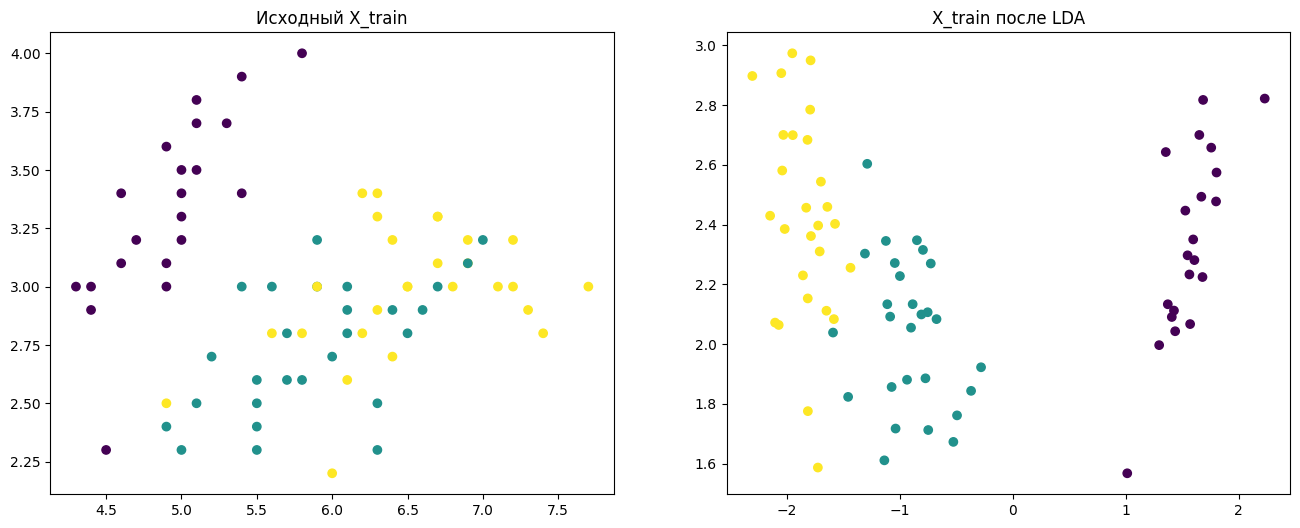

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 6)
ax1.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=y_train)
ax1.title.set_text("Исходный X_train")
ax2.scatter(X_train_new[:, 0], X_train_new[:, 1], marker='o', c=y_train)
ax2.title.set_text("X_train после LDA")

### классификация после применения LDA

теперь попробуем заняться классификацией сортов ирисов из `X_test`. для этого предположим, что точки на картинке 2 распределены по двумерному гауссову распределению. вычислим его параметры:

In [112]:
X_sorts = {}
means = {}
covs = {}

for sort in range(3):
    X_sorts[sort] = np.array(X_train_new[y_train == sort])
    means[sort] = X_sorts[sort].mean(axis=0)
    covs[sort] = np.cov(X_sorts[sort].T)

    print("sort", sort)
    print("means", means[sort])
    print("cov matrix \n", covs[sort], "\n")

sort 0
means [1.57162052 2.33450798]
cov matrix 
 [[0.05791076 0.05787727]
 [0.05787727 0.09773705]] 

sort 1
means [-0.91632062  2.04100148]
cov matrix 
 [[ 0.09598463 -0.02138145]
 [-0.02138145  0.06202162]] 

sort 2
means [-1.84684005  2.41665184]
cov matrix 
 [[ 0.04070195 -0.02313953]
 [-0.02313953  0.12203598]] 



применим MLE -- посмотрим, для какого из классов максимизируется функция логарифм правдоподобия (источник лог-функции: https://stats.stackexchange.com/a/351550)

\begin{aligned}
	l(\mu, \Sigma ; ) & = - \frac{mp}{2} \log (2 \pi) - \frac{m}{2} \log |\Sigma|  - \frac{1}{2}  \sum_{i=1}^m  \mathbf{(x^{(i)} - \mu)^T \Sigma^{-1} (x^{(i)} - \mu) }  
\end{aligned}

In [113]:
def mle(mu, cov, x):
    return -np.log( np.linalg.det(cov) ) - 0.5 * (x - mu).T @ np.linalg.inv(cov) @ (x - mu)

In [114]:
def guess(x):
    return max([0, 1, 2], key=lambda sort: mle(means[sort], covs[sort], x))

для каждой точки из `X_test` будем определять, в каком сорте значение `mle` больше

In [115]:
X_test_new = X_test @ W
y_guess = [ guess(x) for x in X_test_new ]

Метрики:

In [116]:
accuracy = sum(y_guess == y_test) / len(y_guess == y_test)
accuracy

0.96

### sklearn

далее воспользуемся готовым методом LDA из библиотеки sklearn:

In [117]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
clf.predict(X_test)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 1, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0,
       1, 2, 0, 1, 2, 0, 2, 2, 1])

точность:

In [118]:
clf.score(X_test, y_test)

0.9866666666666667

можно заметить, что решение через библиотеку ужасно примитивное и занимает две строчки

### sklearn modification

изменим параметр `solver`

In [119]:
clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage=0.1)
clf.fit(X_train, y_train)
clf.predict(X_test)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0,
       1, 2, 0, 1, 2, 0, 2, 2, 1])

точность:

In [120]:
clf.score(X_test, y_test)

1.0